# Exercises - GEO4902-03 - Ensemble Prediction

Kjersti Stangeland, Fall 2024

# Exercise 03-01 - Ensemble prediction of a precipitation extreme event

The script gives you a framework to assess ensemble forecasts from the Scandinavian ensemble forecasting system. All 10 ensemble members are within one forecast file.

The extreme precipitation event (Telemark, Agder, Vestfold) occurred on 13th July 2019.

- You can decide on an initial time you want to use to assess the ensemble forecasts. In total, use two different initial times to get an idea of predictability for this event.

In [2]:
# import packages
import xarray as xr
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm

#### Load ensemble forecast

In [3]:
year =  '2019'
day  =  '11'
month = '07'
hour_1  ='06'

url = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/'+year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

In [4]:
year =  '2019'
day  =  '13'
month = '07'
hour_1  ='06'

url = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/'+year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_2 = xr.open_dataset(url)

In [5]:
# As we're only looking at precipitation in this exercise, to spare some memory, I will only keep the datavariable I need and drop all the other ones
fc_11 = forecast_1.precipitation_amount_acc
fc_13 = forecast_2.precipitation_amount_acc

__First task__
- Plot the spatial maps of 6-hour accumulated precipitation for different ensemble members. Note the variable in the forecast file is accumulated precipitation from the start of the forecast, so you need to “de-accumulate” the fields. You will note differences between all the 10 ensemble members.

In [6]:
fc_11_now = fc_11.isel(time=-7)
fc_11_6hr_ago = fc_11.isel(time=-7 - 6)
fc_11_6hracc = fc_11_now - fc_11_6hr_ago

In [7]:
fc_13_now = fc_13.isel(time=12)
fc_13_6hr_ago = fc_13.isel(time=12 - 6)
fc_13_6hracc = fc_13_now - fc_13_6hr_ago

Text(0.5, 0.98, 'Forecasted 6hr accumulated precipitation 18 UTC 13th July 2019')

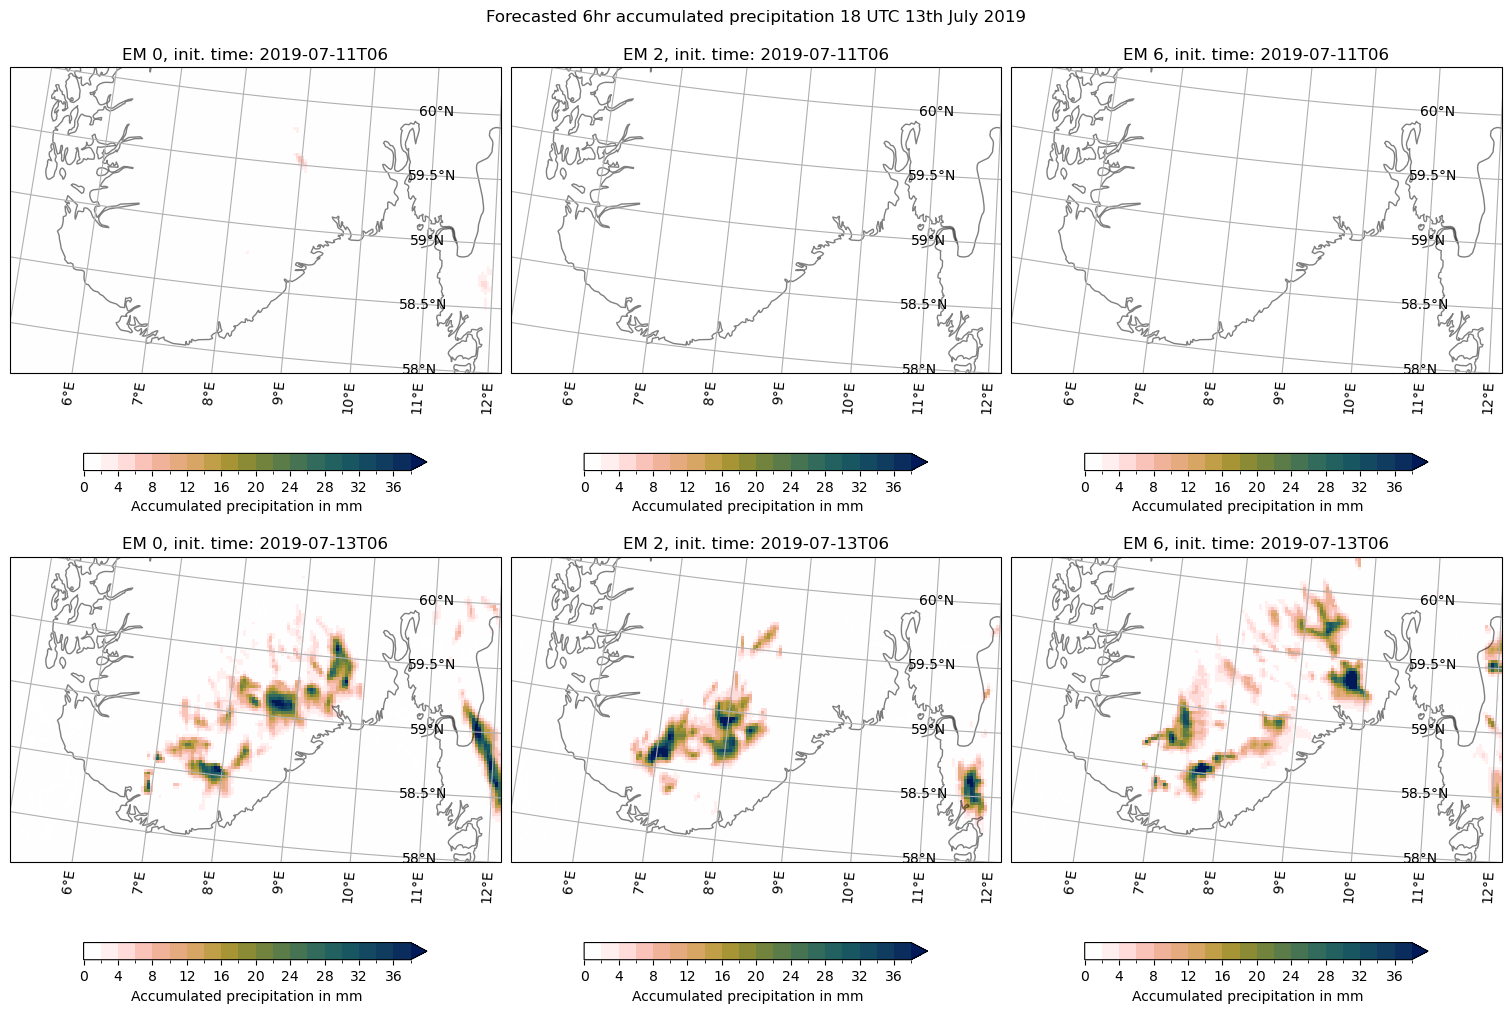

In [8]:
projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0)
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': projection}, figsize=(15, 10), constrained_layout=True)

for axs in ax.flatten():
    axs.set_extent([5, 12, 58, 60], crs=cy.crs.PlateCarree())
    axs.add_feature(cy.feature.COASTLINE, alpha=0.5)
    axs.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = axs.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = True

forecast_times = [np.datetime_as_string(forecast_1.time[0], unit='h'), np.datetime_as_string(forecast_2.time[0], unit='h')]
datasets = [fc_11_6hracc, fc_13_6hracc] # the two forecasts initialized at different times
members = [0, 2, 6]  # Ensemble members
titles = ['EM 0', 'EM 2', 'EM 6']

for i, dataset in enumerate(datasets):
    for j, member in enumerate(members):
        dataset.isel(ensemble_member=member, height0=0).plot.pcolormesh(
            ax=ax[i, j], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',
            levels=np.arange(0, 40, 2), transform=cy.crs.PlateCarree(),
            cbar_kwargs={'orientation': 'horizontal', 'label': 'Accumulated precipitation in mm', 'shrink': 0.7, 'pad': 0.1}
        )
        ax[i, j].set_title(f'{titles[j]}, init. time: {forecast_times[i]}')

# Add figure title
fig.suptitle('Forecasted 6hr accumulated precipitation 18 UTC 13th July 2019')

__Comments on first task:__
- It is clear to see that the forecats initialized 11.07.19 did not see the large precipiation event on 13.07.19 coming. One of the members (EM 0) forecasted some precipition, while the others had nothing. 
- The forecast initialized 13.07.19 forecasted precipiation over the southern part of Norway. However the members did not agree on the severity of the precipitation amount or the location of it. 

__Second task__
- Do you have ideas on how to derive forecast products that combine the information of the 10 ensemble members but still give information about the severity (i.e., the extreme) of the forecasted weather situation?

__Answers second task__
- To derive a forecast product which combines the 10 different ensemble members I would compute the ensemble mean, both in space and time, and then include the spread of the ensembles to show th extremes of the ensembles deviating most from the mean. For a point forecast of for instance temperature: plot a full line representing the ensemble mean through time and have a colored area around it showing the spread. 

__Third task__
- Plot your own ensemble forecast product (from part 3) or derive a forecast plot that shows the probability of 6 hourly precipitation which exceeds a certain threshold (e.g., 20 mm per 6 hours).

In [9]:
# Making my own ensemble forecast, choosing air temperature, using the forecast initialized at 13.07.19 
temp = forecast_2.air_temperature_2m
ensemble_mean = temp.mean(dim='ensemble_member')

In [10]:
# Ensemble variance and ensemble spread
ensemble_var = temp.var(dim='ensemble_member')
ensemble_spread = ensemble_var.mean(dim='time')**(0.5)

In [11]:
ensemble_var

<xarray.DataArray 'air_temperature_2m' (time: 67, height1: 1, y: 949, x: 889)> Size: 226MB
array([[[[3.32669020e-01, 3.26259881e-01, 3.83615255e-01, ...,
          5.69418259e-02, 6.07169494e-02, 5.96285574e-02],
         [3.34029287e-01, 3.26697499e-01, 4.02922928e-01, ...,
          5.09907082e-02, 5.73033318e-02, 5.40174656e-02],
         [2.86558539e-01, 2.51105905e-01, 3.85447294e-01, ...,
          5.20603769e-02, 6.35544881e-02, 6.04188964e-02],
         ...,
         [3.98615837e-01, 3.81138861e-01, 3.58471423e-01, ...,
          5.36976568e-02, 5.50244935e-02, 5.54615445e-02],
         [3.86602461e-01, 3.71299535e-01, 3.51690680e-01, ...,
          5.00443801e-02, 5.17843142e-02, 5.16456738e-02],
         [3.69770944e-01, 3.61534119e-01, 3.43893260e-01, ...,
          4.55637351e-02, 4.77984026e-02, 4.83872779e-02]]],


       [[[1.09790839e-01, 1.20843075e-01, 1.30304143e-01, ...,
          1.49444968e-01, 1.43295661e-01, 1.50044233e-01],
         [9.32789668e-02, 1.02610506e-01, 1.12345114e-01, ...,
          1.17879078e-01, 1.43680781e-01, 1.60201311e-01],
         [7.82128870e-02, 8.50761682e-02, 1.00750171e-01, ...,
...
         [1.24369875e-01, 1.05990306e-01, 8.93712193e-02, ...,
          4.30643559e-06, 1.49011612e-08, 1.83597207e-04],
         [1.14913717e-01, 1.04564443e-01, 8.92253071e-02, ...,
          6.57141209e-06, 4.30643559e-06, 2.26646662e-05]]],


       [[[6.86885267e-02, 4.91960198e-02, 3.45636755e-02, ...,
          1.46265164e-01, 1.90020218e-01, 2.35447660e-01],
         [9.68188196e-02, 7.95829445e-02, 5.63714653e-02, ...,
          1.73170581e-01, 2.35447660e-01, 2.81060457e-01],
         [1.48326531e-01, 1.17409959e-01, 7.95829445e-02, ...,
          2.26995483e-01, 2.80801654e-01, 3.27627659e-01],
         ...,
         [1.63159981e-01, 1.42369881e-01, 1.18248001e-01, ...,
          1.43200159e-05, 8.08969140e-04, 3.56318057e-03],
         [1.54597178e-01, 1.32417098e-01, 1.09193459e-01, ...,
          1.62273645e-05, 4.66838479e-04, 2.14041770e-03],
         [1.32417098e-01, 1.18080154e-01, 9.77325588e-02, ...,
          3.72529030e-07, 1.12786889e-04, 8.08969140e-04]]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 536B 2019-07-13T06:00:00 ... 2019-07-16
  * x          (x) float32 4kB -1.022e+06 -1.02e+06 ... 1.195e+06 1.198e+06
  * y          (y) float32 4kB -1.129e+06 -1.127e+06 ... 1.238e+06 1.241e+06
  * height1    (height1) float32 4B 2.0
    latitude   (y, x) float64 7MB ...
    longitude  (y, x) float64 7MB ...

In [12]:
def findindex(alat,alon,plat,plon):
    # finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    # print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

# Vrådal Telemark
lon = 8.4941; lat= 59.3508
[xloc,yloc] = findindex(temp.latitude, temp.longitude, lat, lon) 

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46478/408797443.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46478/408797443.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


Text(0.5, 0.98, 'Temperature forecast 2019-07-13T18:00:00.000000000')

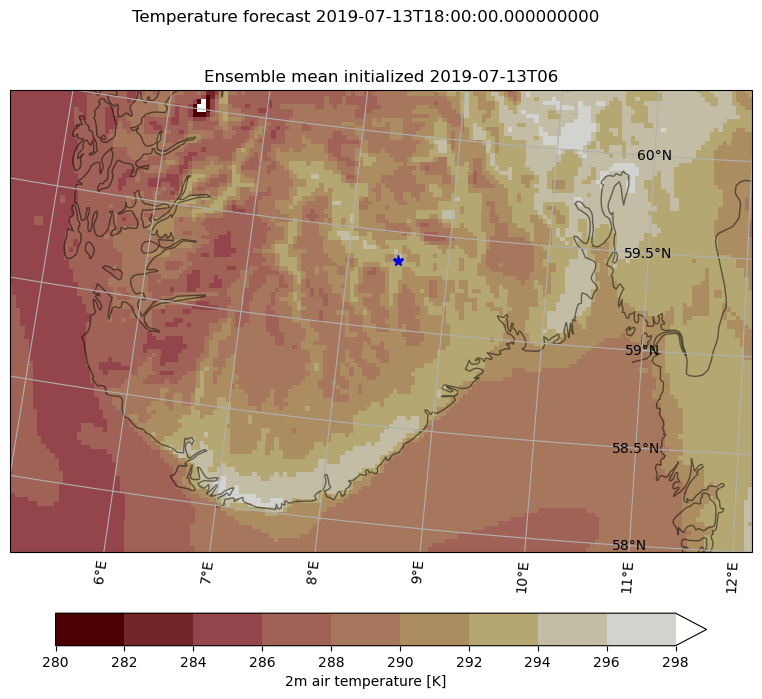

In [13]:
# Spatial ensemble mean forecast
projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(12, 8))

ax.set_extent([5, 12, 58, 60], crs=cy.crs.PlateCarree())
ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
ax.add_feature(cy.feature.BORDERS, alpha=0.5)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = True

ensemble_mean.isel(time=12, height1=0).plot.pcolormesh(ax=ax, x='longitude', y='latitude', cmap=cm.bilbao, extend='max',
            levels=np.arange(280, 300, 2), transform=cy.crs.PlateCarree(),
            cbar_kwargs={'orientation': 'horizontal', 'label': '2m air temperature [K]', 'shrink': 0.7, 'pad': 0.1}
        )
ax.plot(lon, lat, transform = cy.crs.PlateCarree(), color = 'blue', marker ='*', markersize=8)
ax.set_title(f'Ensemble mean initialized {forecast_times[1]}')

fig.suptitle(f'Temperature forecast {np.datetime_as_string(ensemble_mean.time[12])}')

In [14]:
spread_Vradal = (ensemble_spread.isel(height1 = 0, x = xloc, y = yloc).values).item()

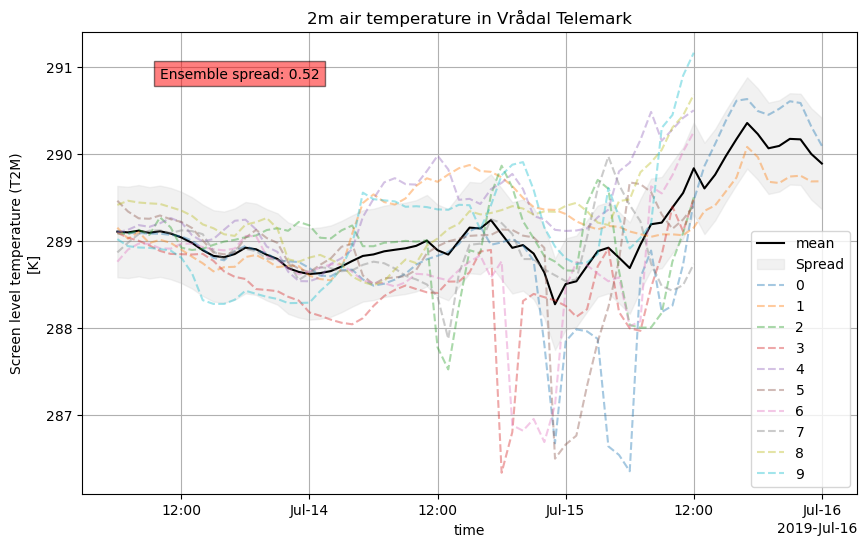

In [15]:
# Point forecast of Vrådal

fig, ax = plt.subplots(figsize=(10,6))

ensemble_mean.isel(height1=0, x=xloc, y=yloc).plot.line(ax=ax, color='black' ,label = 'mean')

ax.fill_between(ensemble_mean.time, ensemble_mean.isel(height1=0, x=xloc, y=yloc) - spread_Vradal, ensemble_mean.isel(height1=0, x=xloc, y=yloc) + spread_Vradal, color="lightgrey", alpha=0.3, label="Spread")

for i in range(0,10):
    temp.isel(height1=0, x=xloc, y=yloc, ensemble_member=i).plot.line(ax=ax, linestyle='--', alpha=0.4,label =temp.ensemble_member[i].values)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_pos = xlim[0] + 0.1 * (xlim[1] - xlim[0])  # 10% from the left
y_pos = ylim[0] + 0.9 * (ylim[1] - ylim[0])  # 90% up

ax.text(x=x_pos, y=y_pos, s= f'Ensemble spread: {spread_Vradal:.2f}', bbox=dict(facecolor='red', alpha=0.5))    
ax.grid()
ax.set_title('2m air temperature in Vrådal Telemark')
ax.legend()

__Comments on task 3:__
- I chose to not look at precipitation for the ensemble forecast as the de-accumulating took to much time and computation power. I tried choosing forecasts per member and using xarray "diff" to get precipitation values per hour. 
- The forecasted temperatures differs a bit as expected, but a spread of 0.52 K is not very large. I interpet this as: the different members forecasted different temperatures, but most of them are within in an interval of 0.52K around the ensemble mean, and thus the ensemble mean can be trusted. If the spread was larger, we could expect more 'extremes'.

should have plotted the standard deviation over time as the "spread" in the point forecast. Normally we take the variance through space, so you would get a spread varying with time for the forecast.